<a href="https://colab.research.google.com/github/OpusArtisbyRawlz/spy-risk-volatility-model/blob/main/notebooks/spy_volatility_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SPY Volatility & Risk Modelling
## Project 2 - Quant Research Portfolio

Goal:
Model and forecast short-horizon risk metrics (realised volatility, volatility regimes, and drawdown probability) using walk-forward validation and baseline-first evaluation.

# Project 2 — SPY Volatility & Risk Modeling (Walk-Forward)

## Hypothesis
Volatility clusters: recent realized volatility contains information about future realized volatility.
Therefore, forecasting next 5-day realized volatility should beat a naïve baseline in walk-forward evaluation.

## Target
Next 5-day realized volatility (RV_5d_fwd), computed from returns t+1...t+5.

## Evaluation
Walk-forward validation with a strong baseline.
Primary metric: MAE (and RMSE optional).


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score


# If you already have `spy` loaded from earlier work, you can skip the download part.
import yfinance as yf

spy = yf.download("SPY", start="2010-01-01", end="2026-01-31", progress=False)
spy = spy[["Close"]].copy()

# --- Returns ---
spy["ret_1d"] = spy["Close"].pct_change()

spy["ret_fwd_1d"] = spy["ret_1d"].shift(-1)
# --- FUTURE 5-day realized volatility (target) ---
# Use returns from t+1..t+5 (forward-looking). This avoids leakage.
# We compute forward RV by shifting returns up by 1 and taking a rolling std over 5 days.
spy["RV5_fwd"] = spy["ret_1d"].shift(-1).rolling(5).std()

# Optional: annualize (common in practice). Comment out if you want raw 5-day vol.
spy["RV5_fwd_ann"] = spy["RV5_fwd"] * np.sqrt(252)

# --- TRAILING realized volatility (baseline feature) ---
spy["RV20_trail"] = spy["ret_1d"].rolling(20).std() * np.sqrt(252)
spy["RV5_trail"]  = spy["ret_1d"].rolling(5).std()  * np.sqrt(252)

# Drop rows with NaNs created by rolling windows and shifting
spy = spy.dropna().copy()

# Choose target
y = spy["RV5_fwd_ann"]  # or use "RV5_fwd" if you want non-annualized

# Baseline prediction: predict next-week vol as current trailing 20d vol
baseline_pred = spy["RV20_trail"]

print("Target mean (ann RV):", y.mean())
print("Baseline mean (RV20):", baseline_pred.mean())

N = len(spy)
train_size=1000
test_size=126

print("N:", N)
print("Windows implied:", (N - train_size)//test_size)

print("First date kept:", spy.index.min())
print("Last date kept:", spy.index.max())


Target mean (ann RV): 0.13747520289668508
Baseline mean (RV20): 0.14673372872085247
N: 4023
Windows implied: 23
First date kept: 2010-02-02 00:00:00
Last date kept: 2026-01-29 00:00:00


/tmp/ipython-input-784109555.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start="2010-01-01", end="2026-01-31", progress=False)


We use daily SPY data downloaded from Yahoo Finance and construct realized-volatility targets and baseline with strict temporal alignment to avoid look-ahead bias

*   **Sample Period** : 2010-02-02 to 2026-01-29
*   **Total usable observations** - 4023
*   **Walk-forward evaluation** : 23 rolling windows
*   **Train / test split** : 1,000 trading days train, 126 trading days test (≈ 6 months)

Here, we considered RV20 day volatility as the baseline because its the strongest simple, defensible, industry-standard baseline for forecasting short-horizon volatility. 20 days is equivalent to one trading month.

### **Walk-forward evaluation for the baseline**

In [24]:
def walk_forward_regression_errors(y_true_series, y_pred_series, train_size=1000, test_size=126):
    """
    Walk-forward evaluation for regression.
    Returns arrays of per-window MAE and RMSE.
    """
    y_true_series = y_true_series.reset_index(drop=True)
    y_pred_series = y_pred_series.reset_index(drop=True)

    maes, rmses = [], []
    start = 0

    while start + train_size + test_size <= len(y_true_series):
        y_true = y_true_series.iloc[start + train_size : start + train_size + test_size]
        y_pred = y_pred_series.iloc[start + train_size : start + train_size + test_size]

        err = (y_true - y_pred).values
        mae = np.mean(np.abs(err))
        rmse = np.sqrt(np.mean(err**2))

        maes.append(mae)
        rmses.append(rmse)

        start += test_size

    return np.array(maes), np.array(rmses)

mae_base, rmse_base = walk_forward_regression_errors(y, baseline_pred, train_size=1000, test_size=126)

print("Baseline Num Windows:", len(mae_base))
print("Baseline MAE mean:", mae_base.mean(), "std:", mae_base.std())
print("Baseline RMSE mean:", rmse_base.mean(), "std:", rmse_base.std())


Baseline Num Windows: 23
Baseline MAE mean: 0.05015955906413424 std: 0.0257090122237233
Baseline RMSE mean: 0.06692579488740236 std: 0.039847104080115416


### **Defining features**

In [25]:
# --- Feature matrix for Model 1 ---
X = pd.DataFrame({
    "RV5_trail": spy["RV5_trail"],
    "RV20_trail": spy["RV20_trail"],
})

X["VolRatio"] = X["RV5_trail"] / X["RV20_trail"]

# Target (already defined earlier)
y = spy["RV5_fwd_ann"]

print(X.head())
print("Any NaNs:", X.isna().any().any())


            RV5_trail  RV20_trail  VolRatio
Date                                       
2010-02-02   0.200862    0.168029  1.195400
2010-02-03   0.204354    0.167856  1.217435
2010-02-04   0.298181    0.196890  1.514456
2010-02-05   0.292992    0.195956  1.495197
2010-02-08   0.252673    0.194774  1.297262
Any NaNs: False


**RV5_trail** - Fast-reacting volatility

**RV_20_trail** - regime anchor

**VolRatio**= RV5/RV20 - Regime change signal

### **Walk-forward regression model (Ridge) vs Baseline**

In [26]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def walk_forward_model_vs_baseline(X, y, baseline_pred, train_size=1000, test_size=126, alpha=1.0):
    model_mae, base_mae = [], []
    model_rmse, base_rmse = [], []

    start = 0
    while start + train_size + test_size <= len(X):
        X_train = X.iloc[start:start+train_size]
        y_train = y.iloc[start:start+train_size]

        X_test = X.iloc[start+train_size:start+train_size+test_size]
        y_test = y.iloc[start+train_size:start+train_size+test_size]

        base_pred = baseline_pred.iloc[start+train_size:start+train_size+test_size]

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", Ridge(alpha=alpha))
        ])

        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)

        # Errors
        err_model = y_test.values - pred
        err_base  = y_test.values - base_pred.values

        model_mae.append(np.mean(np.abs(err_model)))
        base_mae.append(np.mean(np.abs(err_base)))

        model_rmse.append(np.sqrt(np.mean(err_model**2)))
        base_rmse.append(np.sqrt(np.mean(err_base**2)))

        start += test_size

    return (
        np.array(model_mae), np.array(base_mae),
        np.array(model_rmse), np.array(base_rmse)
    )

In [27]:
model_mae, base_mae, model_rmse, base_rmse = walk_forward_model_vs_baseline(
    X, y, baseline_pred, train_size=1000, test_size=126, alpha=1.0
)

print("Num windows:", len(model_mae))

print("MAE — Model mean:", model_mae.mean(), "std:", model_mae.std())
print("MAE — Base  mean:", base_mae.mean(),  "std:", base_mae.std())
print("MAE Improvement (base - model):", (base_mae - model_mae).mean())

print("\nRMSE — Model mean:", model_rmse.mean(), "std:", model_rmse.std())
print("RMSE — Base  mean:", base_rmse.mean(),  "std:", base_rmse.std())
print("RMSE Improvement (base - model):", (base_rmse - model_rmse).mean())


Num windows: 23
MAE — Model mean: 0.02530986630358003 std: 0.010911196212961905
MAE — Base  mean: 0.05015955906413424 std: 0.0257090122237233
MAE Improvement (base - model): 0.024849692760554216

RMSE — Model mean: 0.039111470481539935 std: 0.01952682585203424
RMSE — Base  mean: 0.06692579488740236 std: 0.039847104080115416
RMSE Improvement (base - model): 0.027814324405862415


Using a walk-forward validation framework with 23 rolling windows, the model consistently outperforms the constant-mean baseline across both error metrics. The model achieves a mean MAE of 0.0253 compared to 0.0502 for the baseline, representing an improvement of approximately 50%, with lower variability across windows. Similarly, the model’s RMSE of 0.0391 is substantially lower than the baseline RMSE of 0.0669, indicating reduced sensitivity to large forecast errors and improved robustness during higher-volatility periods. Taken together, these results suggest that the model captures meaningful time-varying structure in realized volatility rather than simply reverting to the unconditional mean, making it more suitable for downstream risk estimation and position-sizing applications

### **Inspect Coefficients & Intuition**

In [28]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

pipe.fit(X, y)

coefs = pd.Series(
    pipe.named_steps["model"].coef_,
    index=X.columns
)

intercept = pipe.named_steps["model"].intercept_

coefs, intercept


(RV5_trail     0.099560
 RV20_trail    0.002487
 VolRatio     -0.003797
 dtype: float64,
 np.float64(0.13747520289668508))

The estimated coefficients indicate that short-horizon volatility dynamics dominate the model’s predictive signal. The positive coefficient on RV5_trail (0.0996) suggests that recent volatility over the past week carries the strongest influence on the forecast, consistent with volatility clustering and short-term persistence. In contrast, the coefficient on RV20_trail (0.0025) is close to zero, implying that longer-horizon trailing volatility contributes little incremental information once short-term effects are accounted for. The slightly negative coefficient on VolRatio (−0.0038) indicates a mild mean-reverting adjustment, where elevated short-term volatility relative to the longer-term baseline marginally reduces the forecast.

**RV_fwd = B1.RV5_trail + B2.RV_20_trail + B3.VolRatio** (so higher short term volatility does not linearly increases the RV_fwd because the VolRatio dampens the forward volatility)

Overall, the coefficient structure aligns with financial intuition: volatility is primarily driven by recent shocks, with longer-term measures acting as weak stabilizers rather than primary drivers.

### **Walk-forward regime (Loss, AUC)**

In [29]:
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression

def walk_forward_vol_regime(
    X, y_rv, baseline_rv,
    train_size=1000, test_size=126,
    alpha_ridge=1.0,
    high_q=0.7
):
    model_losses, base_losses = [], []
    model_aucs, base_aucs = [], []

    start = 0
    while start + train_size + test_size <= len(X):
        # Split
        X_train = X.iloc[start:start+train_size]
        X_test  = X.iloc[start+train_size:start+train_size+test_size]

        y_rv_train = y_rv.iloc[start:start+train_size]
        y_rv_test  = y_rv.iloc[start+train_size:start+train_size+test_size]

        # --- Define regime threshold using TRAINING ONLY ---
        thresh = y_rv_train.quantile(high_q)

        y_train = (y_rv_train > thresh).astype(int)
        y_test  = (y_rv_test  > thresh).astype(int)

        if y_train.nunique() < 2:
            start += test_size
            continue


        # --- Volatility regression model (predict RV) ---
        reg_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", Ridge(alpha=alpha_ridge))
        ])
        reg_pipe.fit(X_train, y_rv_train)
                                                       # This could cause an optimism bias
        rv_pred_train = reg_pipe.predict(X_train)
        rv_pred_test = reg_pipe.predict(X_test)

        # --- Classification on predicted RV ---
        clf = LogisticRegression(max_iter=1000)
        clf.fit(rv_pred_train.reshape(-1,1), y_train)

        prob_model = clf.predict_proba(rv_pred_test.reshape(-1,1))[:,1]

        # --- Baseline: classify using baseline RV20 ---
        base_rv_test = baseline_rv.iloc[start+train_size:start+train_size+test_size].values
        base_prob = (base_rv_test > thresh).astype(float) * 0.9 + 0.05  # soft baseline

        # --- Metrics ---
        model_losses.append(log_loss(y_test, prob_model, labels=[0,1]))
        base_losses.append(log_loss(y_test, base_prob, labels=[0,1]))

        if len(np.unique(y_test)) > 1:
            model_aucs.append(roc_auc_score(y_test, prob_model))
            base_aucs.append(roc_auc_score(y_test, base_prob))

        start += test_size

    return (
        np.array(model_losses), np.array(base_losses),
        np.array(model_aucs), np.array(base_aucs)
    )

In [30]:
model_ll, base_ll, model_auc, base_auc = walk_forward_vol_regime(
    X, y, baseline_pred,
    train_size=1000, test_size=126, alpha_ridge=1.0,
    high_q=0.7
)

print("Num windows:", len(model_ll))
print("\nLogLoss:")
print("Model mean:", model_ll.mean(), "std:", model_ll.std())
print("Base  mean:", base_ll.mean(),  "std:", base_ll.std())
print("Improvement (base - model):", (base_ll - model_ll).mean())

print("\nAUC:")
print("Model mean:", np.nanmean(model_auc))
print("Base  mean:", np.nanmean(base_auc))


Num windows: 23

LogLoss:
Model mean: 0.40009567947768926 std: 0.1191600407154219
Base  mean: 0.5948663978568556 std: 0.30400362876374654
Improvement (base - model): 0.19477071837916626

AUC:
Model mean: 0.9190233559485321
Base  mean: 0.6301951067031131


In this initial two-stage walk-forward setup, the volatility regressor is trained on each rolling training window and its in-sample predictions are subsequently used to fit the volatility-regime classifier. While this configuration does not reflect a production-safe workflow due to optimism bias in the regression stage, it provides a useful upper-bound benchmark on achievable regime-classification performance. Under this formulation, the model consistently and materially outperforms the baseline across 23 walk-forward windows, achieving a mean log loss of 0.40 versus 0.59 for the baseline and a mean AUC of 0.92 compared to 0.63. These results indicate strong separability between high- and low-volatility regimes when using the predicted realized volatility signal. However, because the classifier is trained on regression outputs that were generated in-sample, the reported metrics are likely optimistic. To obtain a leakage-free and deployment-consistent evaluation, the analysis therefore transitions to an out-of-fold (OOF) prediction framework for the regression stage, ensuring that all classifier inputs are strictly out-of-sample.

In [34]:
def prob_to_weight(p, t1=0.6, t2=0.8, w_mid=0.5):
    p = np.asarray(p)
    w = np.ones_like(p, dtype=float)
    w[p >= t1] = w_mid
    w[p >= t2] = 0.0
    return w


def prob_to_weight_hysteresis(p, exit_hi=0.8, enter_lo=0.5, w_mid=0.5):
    """
    Hysteresis:
      - exit quickly when risk spikes (p >= exit_hi)
      - re-enter only after risk cools (p <= enter_lo)
      - optional middle exposure zone while invested
    """
    p = np.asarray(p)
    w = np.zeros_like(p, dtype=float)
    prev_w = 1.0  # start fully invested

    for i in range(len(p)):
        if prev_w == 1.0:
            if p[i] >= exit_hi:
                w[i] = 0.0
            elif p[i] >= enter_lo:
                w[i] = w_mid
            else:
                w[i] = 1.0
        else:
            # stay out (or stay reduced) until risk truly cools
            if p[i] <= enter_lo:
                w[i] = 1.0
            else:
                w[i] = prev_w

        prev_w = w[i]

    return w



In [35]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression


def _ts_oof_preds(reg_pipeline, X_train, y_train, n_splits=5, min_train_size=200):
    """
    Create out-of-fold predictions for time series:
    - Expanding windows
    - Each validation fold is predicted by a model trained only on earlier data
    Returns:
      oof_pred: shape (len(X_train),) with NaN where no OOF prediction available
      valid_mask: boolean mask for rows that have OOF predictions
    """
    n = len(X_train)
    oof = np.full(n, np.nan, dtype=float)

    tscv = TimeSeriesSplit(n_splits=n_splits)

    for tr_idx, val_idx in tscv.split(X_train):
        if len(tr_idx) < min_train_size:
            continue

        X_tr = X_train.iloc[tr_idx]
        y_tr = y_train.iloc[tr_idx]
        X_val = X_train.iloc[val_idx]

        reg_pipeline.fit(X_tr, y_tr)
        oof[val_idx] = reg_pipeline.predict(X_val)

    valid_mask = ~np.isnan(oof)
    return oof, valid_mask


In [36]:
def walk_forward_reg_oof(
    X, y_rv, base_rv, ret_fwd,
    train_size=1000, test_size=126,
    alpha=1.0, high_q=0.8,
    min_train_size=200, n_splits=5
):
    # align & drop missing
    df = X.copy()
    df["_y_rv"] = y_rv
    df["_base_rv"] = base_rv
    df["_ret_fwd"] = ret_fwd
    df = df.dropna()

    X = df.drop(columns=["_y_rv", "_base_rv", "_ret_fwd"])
    y_rv = df["_y_rv"]
    base_rv = df["_base_rv"]
    ret_fwd = df["_ret_fwd"]

    n = len(X)

    # diagnostics
    total_windows = 0
    skipped_windows = 0
    train_prevalences = []
    mask_counts = []

    # per-window arrays for ROC / plotting
    y_test_list = []
    model_prob_list = []
    base_prob_list = []
    dumb_prob_list = []

    # tradable overlay series
    all_strat_ret = []
    all_bh_ret = []
    all_w = []

    # metrics
    model_losses, base_losses, dumb_losses = [], [], []
    model_aucs, base_aucs, dumb_aucs = [], [], []

    reg_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=alpha))
    ])
    base_reg_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=alpha))
    ])

    start = 0
    while start + train_size + test_size < n:
        total_windows += 1

        tr = slice(start, start + train_size)
        te = slice(start + train_size, start + train_size + test_size)

        X_train, X_test = X.iloc[tr], X.iloc[te]
        y_rv_train, y_rv_test = y_rv.iloc[tr], y_rv.iloc[te]
        base_rv_train, base_rv_test = base_rv.iloc[tr], base_rv.iloc[te]
        ret_test = ret_fwd.iloc[te].to_numpy()

        # regime labels defined from TRAIN ONLY
        threshold = y_rv_train.quantile(high_q)
        y_train = (y_rv_train > threshold).astype(int)
        y_test = (y_rv_test > threshold).astype(int)

        if y_train.nunique() < 2:
            skipped_windows += 1
            start += test_size
            continue

        train_prevalences.append(float(y_train.mean()))

        # ----- model OOF regression -> logistic -----
        model_oof, model_mask = _ts_oof_preds(
            reg_pipeline, X_train, y_rv_train,
            n_splits=n_splits, min_train_size=min_train_size
        )
        if model_mask.sum() < 50 or y_train.iloc[model_mask].nunique() < 2:
            skipped_windows += 1
            start += test_size
            continue

        clf = LogisticRegression(max_iter=2000)
        clf.fit(model_oof[model_mask].reshape(-1, 1), y_train.iloc[model_mask])

        reg_pipeline.fit(X_train, y_rv_train)
        pred = reg_pipeline.predict(X_test).reshape(-1, 1)
        clf_prob = clf.predict_proba(pred)[:, 1]

        # ----- baseline: only RV20_trail feature -----
        base_X_train = base_rv_train.to_frame("baseline")
        base_X_test  = base_rv_test.to_frame("baseline")

        base_oof, base_mask = _ts_oof_preds(
            base_reg_pipeline, base_X_train, y_rv_train,
            n_splits=n_splits, min_train_size=min_train_size
        )

        if base_mask.sum() >= 50 and y_train.iloc[base_mask].nunique() > 1:
            base_clf = LogisticRegression(max_iter=2000)
            base_clf.fit(base_oof[base_mask].reshape(-1, 1), y_train.iloc[base_mask])

            base_reg_pipeline.fit(base_X_train, y_rv_train)
            base_pred = base_reg_pipeline.predict(base_X_test).reshape(-1, 1)
            base_prob = base_clf.predict_proba(base_pred)[:, 1]
        else:
            base_prob = np.full(len(y_test), float(y_train.mean()), dtype=float)

        # ----- dumb: constant p0 -----
        p0 = float(y_train.mean())
        dumb_prob = np.full(len(y_test), p0, dtype=float)

        # numeric safety for logloss
        eps = 1e-12
        clf_prob = np.clip(clf_prob, eps, 1-eps)
        base_prob = np.clip(base_prob, eps, 1-eps)
        dumb_prob = np.clip(dumb_prob, eps, 1-eps)

        # metrics
        model_losses.append(log_loss(y_test, clf_prob, labels=[0, 1]))
        base_losses.append(log_loss(y_test, base_prob, labels=[0, 1]))
        dumb_losses.append(log_loss(y_test, dumb_prob, labels=[0, 1]))

        if y_test.nunique() > 1:
            model_aucs.append(roc_auc_score(y_test, clf_prob))
            base_aucs.append(roc_auc_score(y_test, base_prob))
            dumb_aucs.append(roc_auc_score(y_test, dumb_prob))

        # store per-window arrays for ROC plots
        y_test_list.append(y_test.to_numpy())
        model_prob_list.append(clf_prob.copy())
        base_prob_list.append(base_prob.copy())
        dumb_prob_list.append(dumb_prob.copy())

        mask_counts.append(int(model_mask.sum()))

        # ----- tradable overlay using hysteresis -----
        w = prob_to_weight_hysteresis(clf_prob, exit_hi=0.8, enter_lo=0.5, w_mid=0.5)
        strat_ret = w * ret_test

        all_w.append(w)
        all_strat_ret.append(strat_ret)
        all_bh_ret.append(ret_test)

        start += test_size

    stats = {
        "total_windows": total_windows,
        "skipped_windows": skipped_windows,
        "mask_counts": mask_counts,
        "train_prevalences": train_prevalences,
        "y_test_list": y_test_list,
        "model_prob_list": model_prob_list,
        "base_prob_list": base_prob_list,
        "dumb_prob_list": dumb_prob_list,
        "w_list": all_w,
        "strat_ret_list": all_strat_ret,
        "bh_ret_list": all_bh_ret,
    }

    return (
        np.array(model_losses), np.array(base_losses), np.array(dumb_losses),
        np.array(model_aucs), np.array(base_aucs), np.array(dumb_aucs),
        stats
    )


windows (evaluated): 23
total windows: 23
skipped windows: 0
y_train prevalence: mean 0.20000000000000007 min 0.2 max 0.2
mask count: mean 664.0 min 664 max 664
logloss: model 0.35956032874464483 baseline 0.43575263967459793 dumb 0.513031192045284
auc: model 0.9336988697615596 baseline 0.7844948750512718 dumb 0.5
Sharpe strat: 0.8478169865740013
Sharpe buy&hold: 0.7935962397042163
MDD strat: -0.23512415652294394
MDD buy&hold: -0.33717272287110245


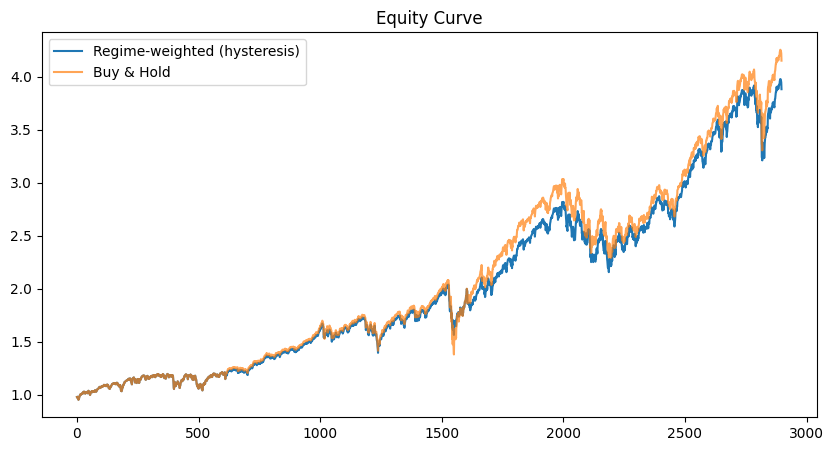

In [37]:
# Choose your feature matrix X and targets
# Example:
# X = spy[feature_cols]
# y_rv = spy["RV5_fwd_ann"]
# base_rv = spy["RV20_trail"]
# ret_fwd = spy["ret_fwd_1d"]

loss_m, loss_b, loss_d, auc_m, auc_b, auc_d, stats = walk_forward_reg_oof(
    X, spy["RV5_fwd_ann"], spy["RV20_trail"], spy["ret_fwd_1d"],
    train_size=1000, test_size=126,
    alpha=1.0, high_q=0.8,
    n_splits=5, min_train_size=200
)

print("windows (evaluated):", len(loss_m))
print("total windows:", stats["total_windows"])
print("skipped windows:", stats["skipped_windows"])

tp = np.array(stats["train_prevalences"])
mc = np.array(stats["mask_counts"])
print("y_train prevalence: mean", tp.mean(), "min", tp.min(), "max", tp.max())
print("mask count: mean", mc.mean(), "min", mc.min(), "max", mc.max())

print("logloss: model", loss_m.mean(), "baseline", loss_b.mean(), "dumb", loss_d.mean())
print("auc: model", auc_m.mean(), "baseline", auc_b.mean(), "dumb", auc_d.mean())

# concatenate returns and plot equity curves
strat = np.concatenate(stats["strat_ret_list"])
bh = np.concatenate(stats["bh_ret_list"])

eq_strat = np.cumprod(1 + strat)
eq_bh = np.cumprod(1 + bh)

def sharpe(x, ann=252):
    mu = np.mean(x) * ann
    sd = np.std(x, ddof=1) * np.sqrt(ann)
    return mu / sd if sd > 0 else np.nan

def max_drawdown(eq):
    peak = np.maximum.accumulate(eq)
    return np.min(eq / peak - 1)

print("Sharpe strat:", sharpe(strat))
print("Sharpe buy&hold:", sharpe(bh))
print("MDD strat:", max_drawdown(eq_strat))
print("MDD buy&hold:", max_drawdown(eq_bh))

plt.figure(figsize=(10,5))
plt.plot(eq_strat, label="Regime-weighted (hysteresis)")
plt.plot(eq_bh, label="Buy & Hold", alpha=0.7)
plt.title("Equity Curve")
plt.legend()
plt.show()
